# Estimating Extreme Risks and Dependence of Stock Indices
#### Research Project for the Course Quantitative Risk Management
Authors: **Nicolo Giacopelli & Oskar Girardin**

## I – Empirical/descriptive analysis

In [35]:
# Import libraries
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from scipy.stats import norm, kurtosis, skew
from itertools import combinations
from collections import defaultdict

# Define colors of graphs
DARK_COL = "#6876a4"
DARK_COL = "#138086"
LIGHT_COL = "#f0b64d"
sns.set_style("whitegrid")

# Function to get tickers of S&P 500
tickers_indeces = ["^GSPC", "^GDAXI", "^FTSE"]

In [2]:
# Download data from 1987 to end of 2022
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2022, 12, 31)
data = yf.download(tickers_indeces, start = start, end = end)
prices = data["Adj Close"]

# Rename columns
prices = prices.rename({"^GSPC": "SP500", "^GDAXI": "DAX", "^FTSE": "FTSE"}, axis = 1)

prices

[*********************100%***********************]  3 of 3 completed


,FTSE,DAX,SP500
Date,,,
1987-01-02,1681.099976,NaN,246.449997
1987-01-05,1680.000000,NaN,252.190002
1987-01-06,1690.699951,NaN,252.779999
1987-01-07,1722.199951,NaN,255.330002
1987-01-08,1733.099976,NaN,257.279999
...,...,...,...
2022-12-23,7473.000000,13940.929688,3844.820068
2022-12-27,NaN,13995.099609,3829.250000
2022-12-28,7497.200195,13925.599609,3783.219971


### 1. Show the plot of the daily prices, $p_i$ of the S&P 500, then describe what you see

In [3]:
def plot_time_series(df, col_name, ylab = 'Price (in US $)', title = None, xlab = "Date"):
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df.index, df[col_name], color = DARK_COL)

    # Set the axis labels and title
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(False)
    # Show the plot
    plt.show()

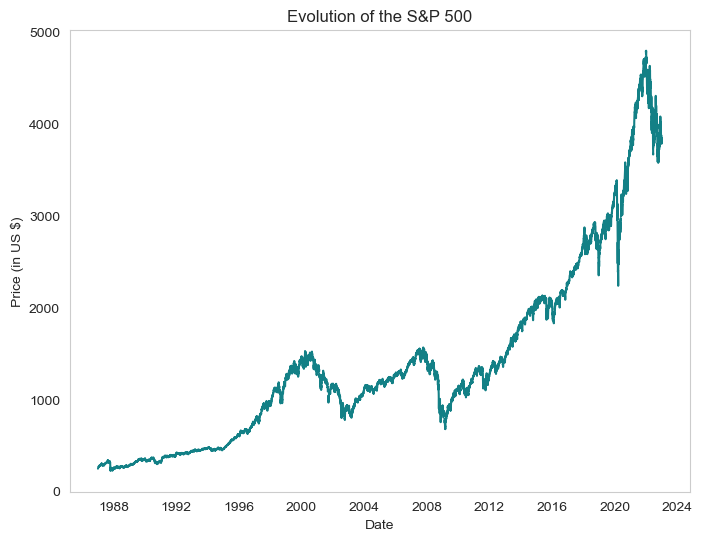

In [4]:
plot_time_series(prices, "SP500", title="Evolution of the S&P 500")

### 2. Transform your three data sets to consider now the daily log return: $$x_i = \log p_i - \log p_{i-1}$$ and give a plot of this new data set (x_i, i = 1,...,n) for the S&P 500. What do you notice? Why did we perform this transformation? We consider the obtained returns as realization of three random variables (rv)’s: $U$ the rv for the S&P 500 returns, $V$ the rv for the FTSE returns, and $W$ the rv for the DAX.

In [5]:
def to_log_returns(prices: pd.Series):
    log_prices = np.log(prices)
    prices_diff = log_prices.diff()
    return prices_diff

In [6]:
returns = prices.apply(to_log_returns, axis = 0)

In [7]:
returns

,FTSE,DAX,SP500
Date,,,
1987-01-02,NaN,NaN,NaN
1987-01-05,-0.000655,NaN,0.023024
1987-01-06,0.006349,NaN,0.002337
1987-01-07,0.018460,NaN,0.010037
1987-01-08,0.006309,NaN,0.007608
...,...,...,...
2022-12-23,0.000495,0.001929,0.005851
2022-12-27,NaN,0.003878,-0.004058
2022-12-28,NaN,-0.004978,-0.012093


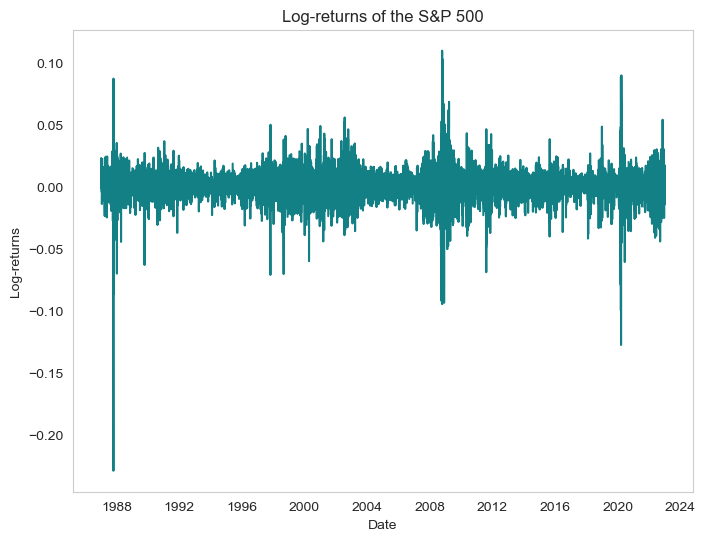

In [8]:
plot_time_series(returns, "SP500", ylab="Log-returns", title= "Log-returns of the S&P 500")

### 3. Present your empirical analysis done on these later data sets in two tables, one for the basic statistics containing: 
1. Descriptive statistics (number of observations, $\mu$, $\sigma$, skewness, kurtosis) 
2. Rank statistics (Maximum, Median, Minimum)

In [9]:
def compute_stats(df):
    moment_functions = ["count", "mean", "std", "skew", "kurt", "min", "median", "max"]
    return df.agg(moment_functions)

In [10]:
basic_stats = compute_stats(returns)
basic_stats

,FTSE,DAX,SP500
count,8899.000000,8668.000000,8855.000000
mean,0.000135,0.000238,0.000311
std,0.011145,0.013956,0.011799
skew,-0.570827,-0.295273,-1.208194
kurt,10.467729,6.780182,25.841746
min,-0.130286,-0.140912,-0.228997
median,0.000500,0.000736,0.000607
max,0.093842,0.107975,0.109572


In [11]:
alpha_var = 0.995
alpha_tvar = 0.99
# Define losses as negative returns
losses = -returns
# Get VAR at 99.5%
VAR = pd.Series(np.quantile(losses.dropna(), q = alpha_var, axis = 0), index = losses.columns)
# Get tVAR at 99%
tVAR = losses[losses > np.quantile(losses.dropna(), q = alpha_tvar, axis = 0)].mean()
# Get VAR and tVAR using gaussian model
means = basic_stats.loc["mean", :]
stds = basic_stats.loc["std", :]
VAR_gaussian = stds*norm.ppf(alpha_var) + means
tVAR_gaussian = stds*(norm.pdf(norm.ppf(alpha_tvar)))/(1-alpha_tvar) + means
# Combine into one dataframe
risk_measures = pd.DataFrame([VAR, VAR_gaussian, tVAR, tVAR_gaussian], index = ["VAR_empirical", "VAR_gaussian", "tVAR_empirical", "tVAR_gaussian"])
risk_measures

,FTSE,DAX,SP500
VAR_empirical,0.037493,0.050432,0.040792
VAR_gaussian,0.028842,0.036186,0.030703
tVAR_empirical,0.044349,0.054378,0.050077
tVAR_gaussian,0.029839,0.037434,0.031758


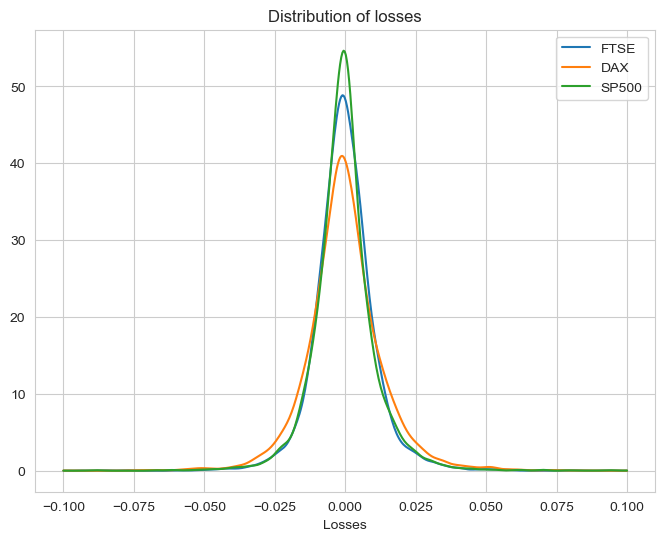

In [12]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    values = losses.iloc[:,i].dropna()
    d = stats.gaussian_kde(values)
    ind = np.linspace(-0.1, 0.1, 500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label=losses.columns[i])

# Set the axis labels and title
plt.xlabel("Losses")
plt.title("Distribution of losses")
plt.legend()
# Show the plot
plt.show()

### e. Build a portfolio, $Z = U + V + W$, with the three indices and compute the empirical VaR of the losses at 99.5% and the TVaR at 99%. Allocate the capital according to: $C(L|P) = \mathbb{E}[L] - \mathbb{E}[L|Z \leq F_Z^{-1}(\alpha)]$, to the three indices in the portfolio.

In [13]:
losses_sync = losses.dropna()
Z = losses_sync.sum(axis = 1)

In [14]:
losses_sync

,FTSE,DAX,SP500
Date,,,
1988-01-06,0.001398,-0.009900,-0.001005
1988-01-07,-0.000056,-0.008374,-0.008385
1988-01-08,0.007752,-0.011974,0.070082
1988-01-11,0.007471,0.038898,-0.016664
1988-01-12,0.012002,0.000638,0.008399
...,...,...,...
2022-12-21,-0.017044,-0.015236,-0.014759
2022-12-22,0.003742,0.013120,0.014557
2022-12-23,-0.000495,-0.001929,-0.005851


In [15]:
mean_losses = losses_sync.mean(axis = 0)
alpha = 0.995
quantile_Z = np.quantile(mean_losses, q = alpha)
capital = np.mean(losses_sync, axis = 0) - np.mean(losses_sync[Z <= quantile_Z], axis = 0)

In [16]:
capital

FTSE     0.006297
DAX      0.008289
SP500    0.005509
dtype: float64

## III. Bivariate analyis

### Draw the ranked scatter plot for the three pairs, do you see a difference?

In [17]:
ftse = losses_sync["FTSE"]
dax = losses_sync["DAX"]
sp500 = losses_sync["SP500"]


def plot_rankscatter(series1, series2, title = None):
    ranks1 = stats.rankdata(series1)
    ranks2 = stats.rankdata(series2)

    fig, ax = plt.subplots(figsize = (8, 6))
    ax.scatter(ranks1, ranks2, s = 2, color = DARK_COL)
    ax.grid(False)
    ax.set_xlabel(series1.name)
    ax.set_ylabel(series2.name)
    ax.set_title(title)
    plt.show()

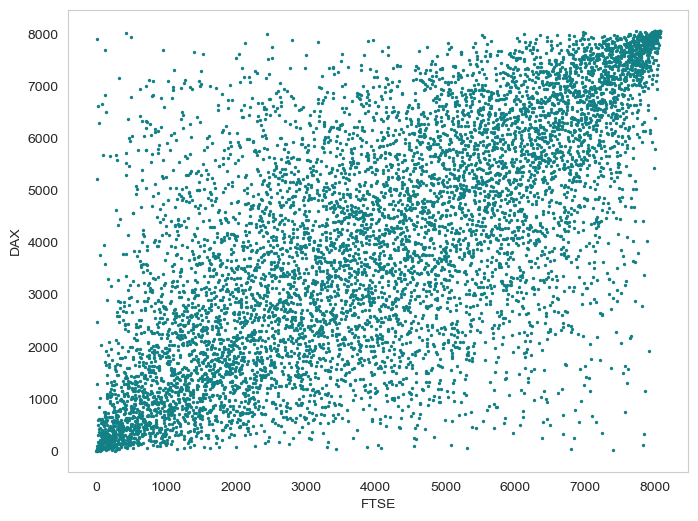

In [18]:
plot_rankscatter(ftse, dax)

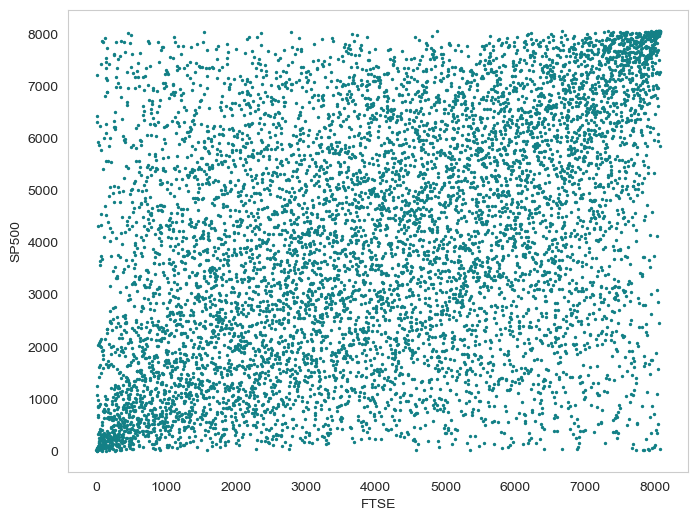

In [19]:
plot_rankscatter(ftse, sp500)

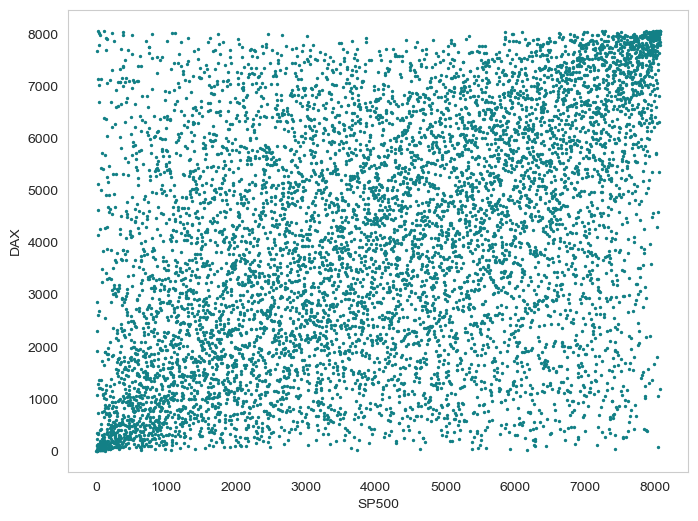

In [20]:
plot_rankscatter(sp500, dax)

In [61]:
# Spearman and Pearson coefficients
def get_correlations(*series_list):
    combs = combinations(series_list, r = 2)
    combs_names = [(x.name, y.name) for x, y in combs]
    res = pd.DataFrame(np.zeros((len(combs_names), 2)), columns=["Spearman", "Pearson"])
    print(combs_names)
    for (x, y) in combs:
        print("yoo")
        cor_spearman = stats.spearmanr(x, y)
        cor_pearson = stats.pearsonr(x, y)
        print(cor_spearman, cor_pearson)
        res.iloc[i,:] = [cor_spearman, cor_pearson]
    return res

In [62]:
get_correlations(sp500, dax, ftse)

[('SP500', 'DAX'), ('SP500', 'FTSE'), ('DAX', 'FTSE')]


,Spearman,Pearson
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
